In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np

import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

from DNN.v4 import Diffractive4, draw_detect_regions
from models.v4 import Dmodel

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
ori_padd = 1
scale_factor = 3
lambd = 0.75e-3
pixel_pitch = 400e-6 / scale_factor
distance = 3e-2
n_layers = 5
n_neuron = int(200 * scale_factor)
n_padd = int(200 * ori_padd * scale_factor)
image_size = int(84 * scale_factor)
margin = int(0 * scale_factor)
seed = 42
lr = 0.001
load_epoch = 0
batch_size = 8
whether_load_model = False
dummy = f'Dummy_scale_{scale_factor}_padd_{ori_padd}'
# dummy = None
load_model_name = './saved_model/06_20_2024_gaussian_loss_97_percent.pth'

In [3]:
transform = transforms.Compose([transforms.Resize((image_size, image_size)), transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST("./data", train=True, transform=transform, download=False)
val_dataset = torchvision.datasets.MNIST("./data", train=False, transform=transform, download=False)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=8, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=False, pin_memory=True)

In [4]:
model = Dmodel(pixel_pitch, distance, n_padd, device, lambd, n_neuron, margin, image_size, scale_factor)
loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=lr)

original_network = Diffractive4(model, loss_fn, optimizer)
original_network.set_loaders(train_dataloader, val_dataloader)

# tracking, fig = original_network.lr_range_test(train_dataloader, end_lr=1e-1, num_iter=100)
if whether_load_model:
    original_network.load_checkpoint(load_model_name, dummy)

In [5]:
original_network.train(1)

In [23]:
original_network.save_checkpoint('saved_model/06_20_2024_gaussian_refine.pth')

In [7]:
Diffractive4.loader_apply(val_dataloader, original_network.compute_correct_rate).sum(dim=0)

tensor([ 9186, 10000])

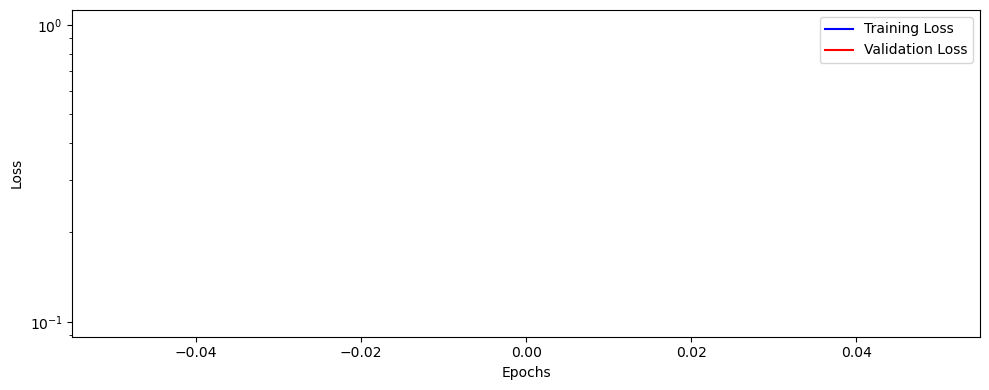

In [6]:
fig = original_network.plot_losses()

In [9]:
# draw_detect_regions()
iterat = iter(train_dataloader)

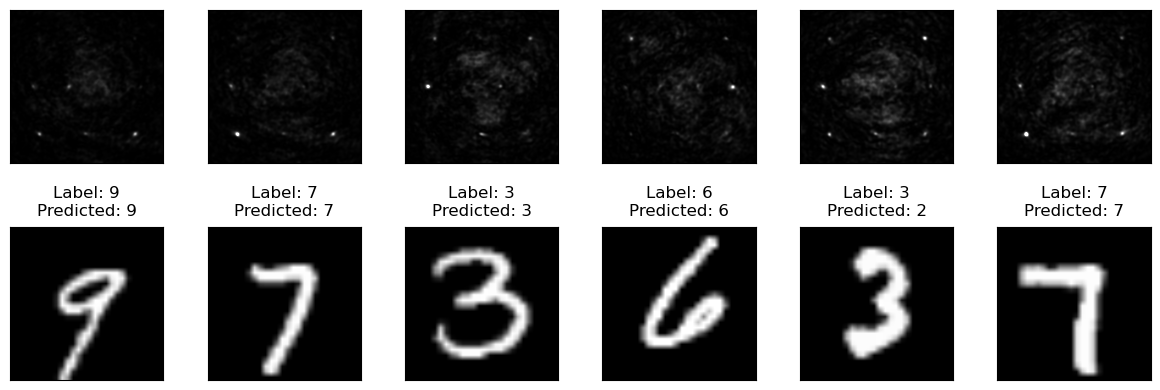

In [22]:
fig_intensity = original_network.plot_intensity(iterat, 6, n_neuron, cut = 50 * scale_factor)

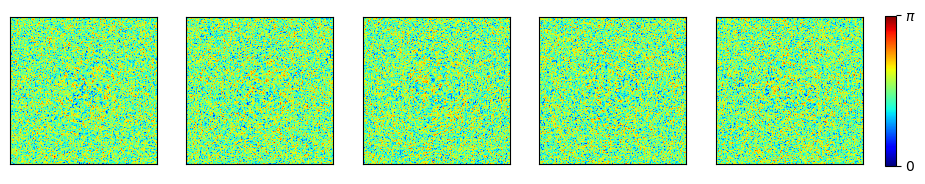

In [11]:
layers_name = ['modulation_1', 'modulation_2', 'modulation_3', 'modulation_4', 'modulation_5']
fig_mask = original_network.visualize_phasemask(layers_name)

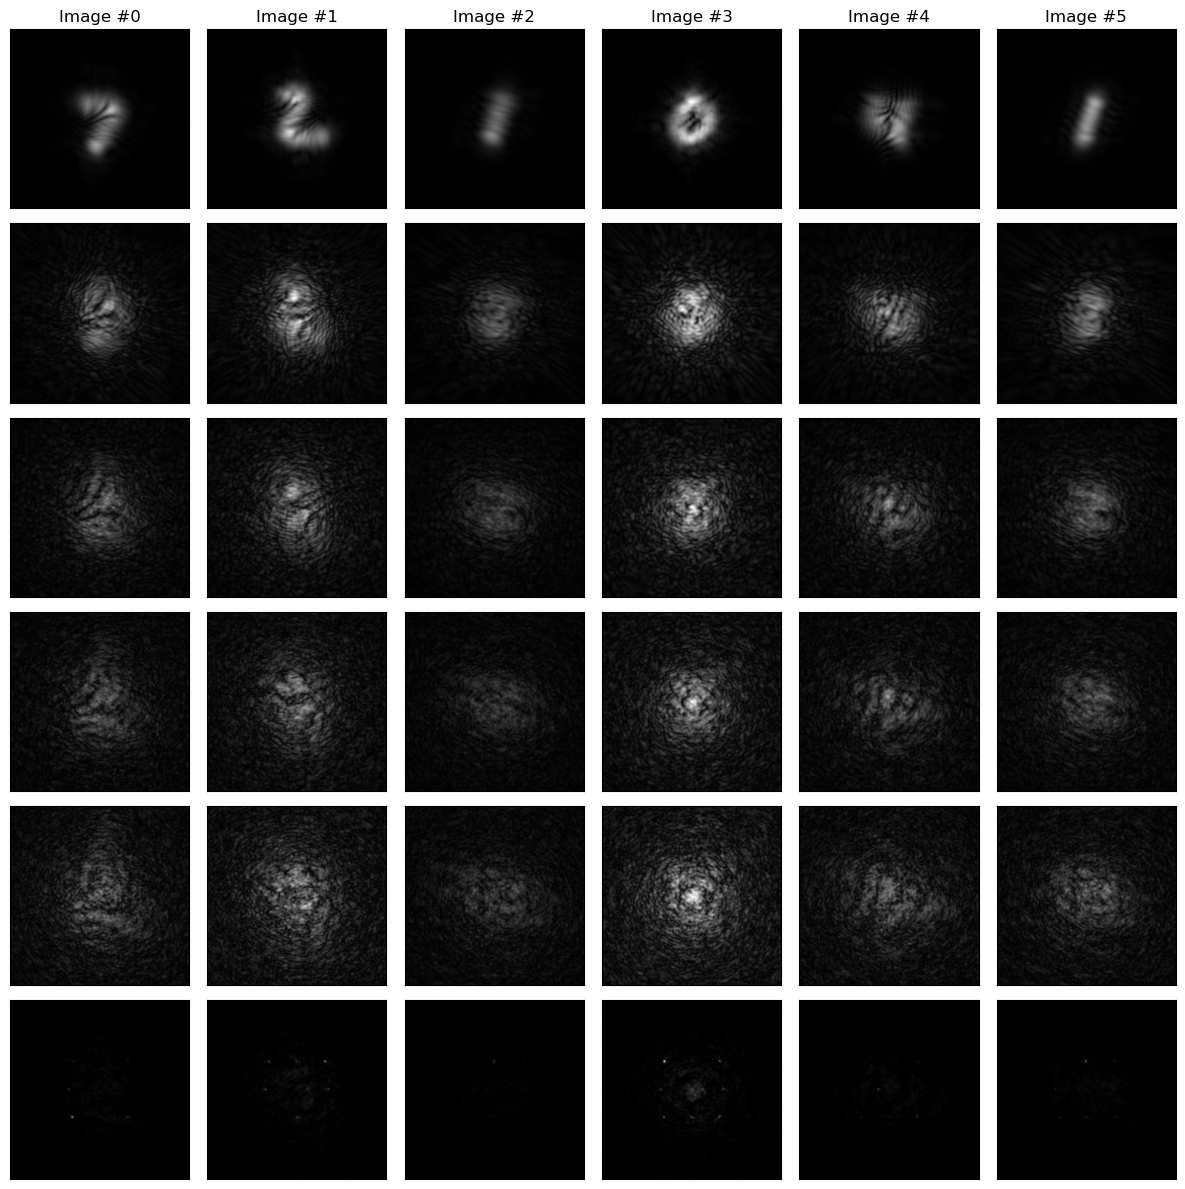

In [12]:
layers_to_hook = ['modulation_1', 'modulation_2', 'modulation_3', 'modulation_4', 'modulation_5', 'intensity_capture']
original_network.attach_hooks(layers_to_hook)

images_batch, labels_batch = next(iter(val_dataloader))
logits = original_network.predict(images_batch)
original_network.remove_hooks()

fig = original_network.visualize_outputs(layers_to_hook, n_neuron, n_padd, n_images=6, y=None, yhat=None)
# To be continued ...